In [1]:
!pip install tensorflow keras numpy matplotlib opencv-python


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Pre-processing Input Data (OHRC and IIRS images)

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Define your dataset paths here
ohrc_image_path = "/content/drive/MyDrive/data_sci/ohrc"
iirs_image_path = "/content/drive/MyDrive/data_sci/iirs"

# Function to load and preprocess images
def preprocess_images(image_path, img_size=(256, 256)):
    images = []
    for file in os.listdir(image_path):
        img = cv2.imread(os.path.join(image_path, file))
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
    return np.array(images)

# Load OHRC and IIRS images
ohrc_images = preprocess_images(ohrc_image_path)
iirs_images = preprocess_images(iirs_image_path)

print("OHRC Images Shape:", ohrc_images.shape)
print("IIRS Images Shape:", iirs_images.shape)


OHRC Images Shape: (2, 256, 256, 3)
IIRS Images Shape: (3, 256, 256, 3)


Define Shared Encoder with Dual Outputs

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from tensorflow.keras.models import Model

def build_shared_encoder(input_shape=(256, 256, 3)):
    input_layer = Input(shape=input_shape)

    # Shared Convolutional Layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Branch for Structural Embeddings
    structural_branch = Flatten()(x)
    structural_embedding = Dense(128, activation='relu', name="structural_embedding")(structural_branch)

    # Branch for Resolution Embeddings
    resolution_branch = Flatten()(x)
    resolution_embedding = Dense(128, activation='relu', name="resolution_embedding")(resolution_branch)

    model = Model(inputs=input_layer, outputs=[structural_embedding, resolution_embedding])
    return model

shared_encoder = build_shared_encoder()
shared_encoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 262144)         │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 262144)         │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ structural_embedding      │ (None, 128)            │     33,554,560 │ flatten[0][0]          │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resolution_embedding      │ (None, 128)            │     33,554,560 │ flatten_1[0][0]        │
│ (Dense)                   │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 67,128,512 (256.07 MB)

 Trainable params: 67,128,512 (256.07 MB)

 Non-trainable params: 0 (0.00 B)

Incorporate Attention Mechanisms

In [ ]:
from tensorflow.keras.layers import Attention

# Example attention layer
def attention_layer(inputs):
    query, value = inputs
    attn = Attention()([query, value])
    return attn


Define Conditional GAN Architecture

In [ ]:
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.models import Sequential

# Define Generator
def build_generator():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Output to 3-channel image
    return model

# Define Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 6)))  # OHRC + IIRS input
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  # Binary classification (real/fake)
    return model

generator = build_generator()
discriminator = build_discriminator()

generator.summary()
discriminator.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 512, 512, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 512, 512, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 512, 512, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,123 (82.51 KB)

 Trainable params: 21,123 (82.51 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 256, 256, 64)        │           3,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │       1,048,577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,052,097 (4.01 MB)

 Trainable params: 1,052,097 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

Define Loss Functions and GAN Training Loop

In [ ]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, UpSampling2D
from tensorflow.keras.models import Sequential, Model

# Define Generator
def build_generator():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
    # Remove or adjust Upsampling2D to maintain the input shape
    # model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Output to 3-channel image
    return model

# Define Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 6)))  # OHRC + IIRS input
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  # Binary classification (real/fake)
    return model

# Define custom loss functions
def perceptual_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Combine generator and discriminator into GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(256, 256, 3))
    enhanced_image = generator(gan_input)
    gan_output = discriminator(concatenate([gan_input, enhanced_image]))  # Concatenate input and enhanced image
    gan = Model(inputs=gan_input, outputs=gan_output)
    return gan

# # Build and compile the models
# generator = build_generator()
# discriminator = build_discriminator()
# gan = build_gan(generator, discriminator)
# gan.compile(optimizer='adam', loss='binary_crossentropy')
# gan.summary()
# ... (your existing code) ...

# Build and compile the models
generator = build_generator()
discriminator = build_discriminator()

# Compile the discriminator
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

gan = build_gan(generator, discriminator)
gan.compile(optimizer='adam', loss='binary_crossentropy')
gan.summary()

# ... (rest of your code) ...

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, 256, 256, 3)    │         21,123 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 256, 256, 6)    │              0 │ input_layer_11[0][0],  │
│ (Concatenate)             │                        │                │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, 1)              │      1,052,097 │ concatenate_2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,073,220 (4.09 MB)

 Trainable params: 21,123 (82.51 KB)

 Non-trainable params: 1,052,097 (4.01 MB)

Train the Model

In [ ]:
# Prepare training data
X = ohrc_images  # Input images
Y = iirs_images  # Target images for conditional GAN

# Training Loop
epochs = 10
batch_size = 16  # Consider reducing batch_size or making your datasets the same size
# Ensure that the batch_size can divide evenly into the smallest dimension
batch_size = min(batch_size, min(len(X), len(Y)))  # Ensure batch_size is suitable

for epoch in range(epochs):
    # Calculate the number of batches to cover the smaller dataset
    num_batches = min(len(X), len(Y)) // batch_size

    # Initialize epoch losses
    epoch_d_loss = 0
    epoch_g_loss = 0

    for batch in range(num_batches):
        # Ensure real_images and target_images have the same batch size
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        real_images = X[start_idx:end_idx]
        target_images = Y[start_idx:end_idx]

        # Generate fake images
        fake_images = generator.predict(real_images)

        # Train discriminator
        real_labels = np.ones((real_images.shape[0], 1))
        fake_labels = np.zeros((fake_images.shape[0], 1))
        d_loss_real = discriminator.train_on_batch(np.concatenate([real_images, target_images], axis=-1), real_labels)
        d_loss_fake = discriminator.train_on_batch(np.concatenate([real_images, fake_images], axis=-1), fake_labels)

        # Access the loss values (first element of the lists)
        d_loss_real = d_loss_real[0]  # Get the loss value from d_loss_real
        d_loss_fake = d_loss_fake[0]  # Get the loss value from d_loss_fake

        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        epoch_d_loss += d_loss  # Accumulate discriminator loss

        # Train generator (via GAN)
        g_loss = gan.train_on_batch(real_images, real_labels)
        # Access the loss value (first element of the list)
        epoch_g_loss += g_loss[0]  # Accumulate generator loss only

    # Calculate average epoch losses
    # Check if num_batches is 0 to prevent ZeroDivisionError
    if num_batches > 0:
        epoch_d_loss /= num_batches
        epoch_g_loss /= num_batches

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {epoch_d_loss:.4f} | G Loss: {epoch_g_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Epoch 1/10 | D Loss: 0.7095 | G Loss: 0.7104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Epoch 2/10 | D Loss: 0.7101 | G Loss: 0.7108
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Epoch 3/10 | D Loss: 0.7106 | G Loss: 0.7113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Epoch 4/10 | D Loss: 0.7112 | G Loss: 0.7119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Epoch 5/10 | D Loss: 0.7118 | G Loss: 0.7124
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Epoch 6/10 | D Loss: 0.7124 | G Loss: 0.7129
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Epoch 7/10 | D Loss: 0.7129 | G Loss: 0.7135
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Epoch 8/10 | D Loss: 0.7135 | G Loss: 0.7141
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Epoch 9/10 | D Loss: 0.7141 | G Loss: 0.7147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Epoch 10/10 | D Loss: 0.7147 | G Loss: 0.7153


Test the Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


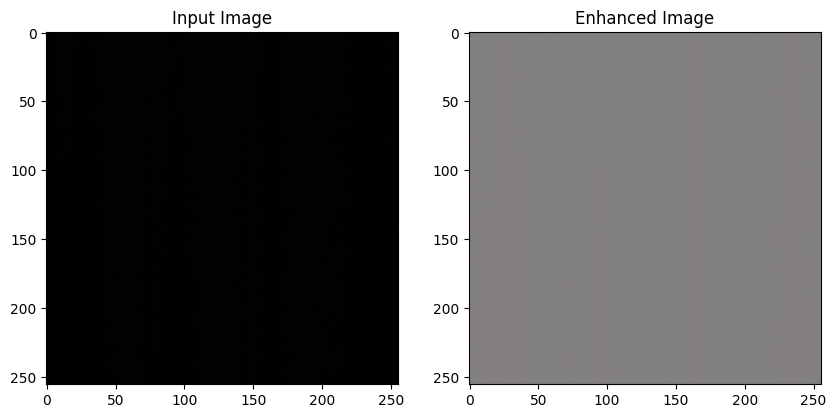

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Input test image path (make sure it's a path to an actual image file)
# Choose an image file within this directory
test_image_path = "/content/drive/MyDrive/data_sci/target/target01.tif"
test_image = cv2.imread(test_image_path)

# Check if the image was loaded successfully
if test_image is None:
    print(f"Error: Could not load image from {test_image_path}")
else:
    test_image = cv2.resize(test_image, (256, 256)) / 255.0
    test_image = np.expand_dims(test_image, axis=0)

    # Generate enhanced image
    enhanced_image = generator.predict(test_image)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(test_image[0])
    plt.subplot(1, 2, 2)
    plt.title("Enhanced Image")
    plt.imshow(enhanced_image[0])
    plt.show()

Denoising Code 1

Final fully denoised and enhanced image saved at: /content/drive/MyDrive/enhanced_images/final_fully_denoised_image.tif


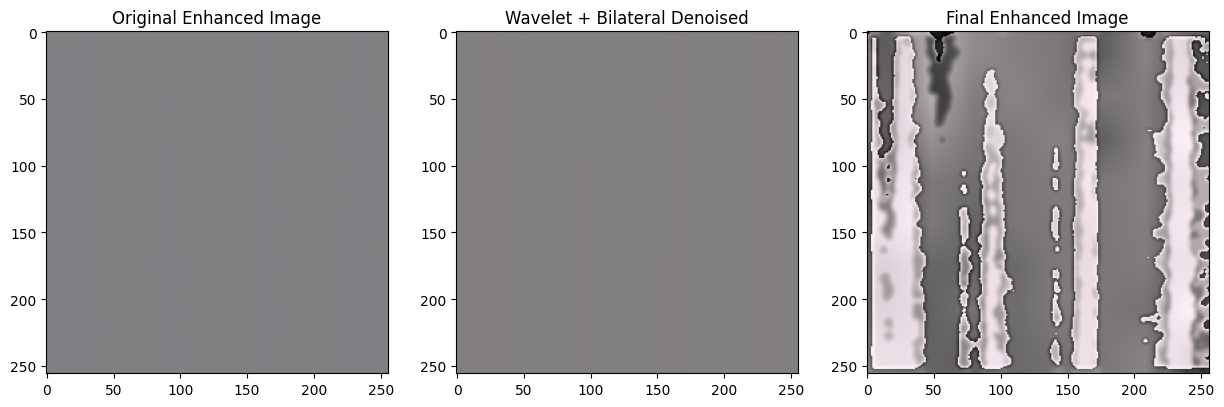

In [ ]:
!pip install scikit-image --upgrade
import cv2
import numpy as np
from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage.filters import unsharp_mask
from skimage import exposure, img_as_ubyte
import matplotlib.pyplot as plt
import os

# Load the saved enhanced image
enhanced_image_path = "/content/drive/MyDrive/enhanced_images/enhanced_image.tif"
processed_image = cv2.imread(enhanced_image_path, cv2.IMREAD_UNCHANGED)
processed_image = processed_image / 255.0  # Normalize for processing

# Step 1: Wavelet Denoising
# Estimate noise level
sigma_est = estimate_sigma(processed_image, channel_axis=-1, average_sigmas=True)  # Update this line
denoised_image = denoise_wavelet(
    processed_image,
    sigma=sigma_est,
    channel_axis=-1,  # Update this line if using an older version
    convert2ycbcr=True,
    method="BayesShrink",
    mode="soft"
)

# Step 2: Bilateral Filtering (Preserves edges while smoothing)
bilateral_filtered = cv2.bilateralFilter(
    (denoised_image * 255).astype(np.uint8),
    d=9,  # Diameter of the filter
    sigmaColor=75,
    sigmaSpace=75
)
bilateral_filtered = bilateral_filtered / 255.0  # Normalize back

# Step 3: Sharpening Using Unsharp Mask
sharpened_image = unsharp_mask(bilateral_filtered, radius=1.5, amount=1.0)

# Step 4: Contrast Enhancement
enhanced_contrast_image = exposure.equalize_adapthist(
    sharpened_image,
    clip_limit=0.03
)

# Step 5: Save the Final Enhanced Image
output_dir = "/content/drive/MyDrive/enhanced_images/"
os.makedirs(output_dir, exist_ok=True)
final_image_path = os.path.join(output_dir, "final_fully_denoised_image.tif")
cv2.imwrite(final_image_path, img_as_ubyte(enhanced_contrast_image))  # Convert to 8-bit before saving

print(f"Final fully denoised and enhanced image saved at: {final_image_path}")

# Step 6: Visualize the Results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Enhanced Image")
plt.imshow(cv2.cvtColor(cv2.imread(enhanced_image_path), cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Wavelet + Bilateral Denoised")
plt.imshow(bilateral_filtered)

plt.subplot(1, 3, 3)
plt.title("Final Enhanced Image")
plt.imshow(enhanced_contrast_image)
plt.show()


Denoising Code 2

In [ ]:
import os

# Output directory for enhanced images
output_dir = "/content/drive/MyDrive/enhanced_images/"
os.makedirs(output_dir, exist_ok=True)

# Save enhanced image
enhanced_image_path = os.path.join(output_dir, "enhanced_image.tif")
cv2.imwrite(enhanced_image_path, (enhanced_image[0] * 255).astype(np.uint8))  # Convert back to [0, 255] before saving

print(f"Enhanced image saved at: {enhanced_image_path}")


Enhanced image saved at: /content/drive/MyDrive/enhanced_images/enhanced_image.tif


In [ ]:
!pip install PyWavelets
from skimage.restoration import denoise_wavelet
from skimage import exposure
import pywt # Import the pywt module

# Load the saved enhanced image for post-processing
processed_image = cv2.imread(enhanced_image_path, cv2.IMREAD_UNCHANGED)
processed_image = processed_image / 255.0  # Normalize for processing

# Apply Wavelet Denoising
# Specify channel_axis=-1 for color images
denoised_image = denoise_wavelet(processed_image, convert2ycbcr=True, channel_axis=-1)

# Apply Contrast Enhancement (Adaptive Histogram Equalization)
enhanced_contrast_image = exposure.equalize_adapthist(denoised_image, clip_limit=0.03)

# Save the final processed image
final_image_path = os.path.join(output_dir, "final_enhanced_image.tif")
cv2.imwrite(final_image_path, (enhanced_contrast_image * 255).astype(np.uint8))

print(f"Final enhanced image saved at: {final_image_path}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 32.7 MB/s eta 0:00:00
Final enhanced image saved at: /content/drive/MyDrive/enhanced_images/final_enhanced_image.tif


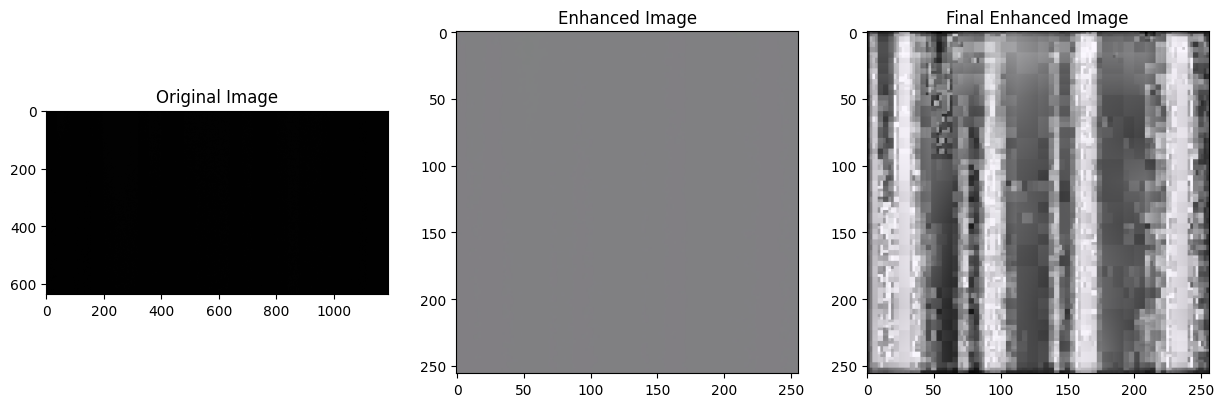

In [ ]:
# Display original, enhanced, and final enhanced images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Enhanced Image")
plt.imshow(cv2.cvtColor(cv2.imread(enhanced_image_path), cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 3)
plt.title("Final Enhanced Image")
plt.imshow(cv2.cvtColor(cv2.imread(final_image_path), cv2.COLOR_BGR2RGB))

plt.show()


Denoising Code part 3

Apply Denoising and Further Enhancement

In [ ]:
import os

# Define a directory to save the enhanced images
output_dir = "enhanced_images"
os.makedirs(output_dir, exist_ok=True)

# Save enhanced images to the output directory
def save_images(images, output_dir, prefix="enhanced"):
    for idx, img in enumerate(images):
        img = (img * 255).astype('uint8')  # Convert back to 8-bit format
        save_path = os.path.join(output_dir, f"{prefix}_image_{idx+1}.png")
        cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))  # Convert to BGR for saving
        print(f"Saved: {save_path}")

# Generate and save enhanced images
enhanced_images = generator.predict(ohrc_images)  # Enhance OHRC images
save_images(enhanced_images, output_dir)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Saved: enhanced_images/enhanced_image_1.png
Saved: enhanced_images/enhanced_image_2.png


Apply Image Enhancement Techniques

In [ ]:
def enhance_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(img)
    return enhanced_img

# ... previous code (import statements and enhance_image function) ...

# Define the path to the denoised image directory
denoised_dir = "/content/enhanced_images"  # Replace with your actual directory path

# Apply enhancement to denoised images
enhanced_dir = "final_enhanced_images"
os.makedirs(enhanced_dir, exist_ok=True)

for file in os.listdir(denoised_dir):
    file_path = os.path.join(denoised_dir, file)
    enhanced_img = enhance_image(file_path)
    save_path = os.path.join(enhanced_dir, f"final_{file}")
    cv2.imwrite(save_path, enhanced_img)
    print(f"Saved Final Enhanced Image: {save_path}")


Saved Final Enhanced Image: final_enhanced_images/final_enhanced_image_1.png
Saved Final Enhanced Image: final_enhanced_images/final_enhanced_image_2.png


 Visualize Results

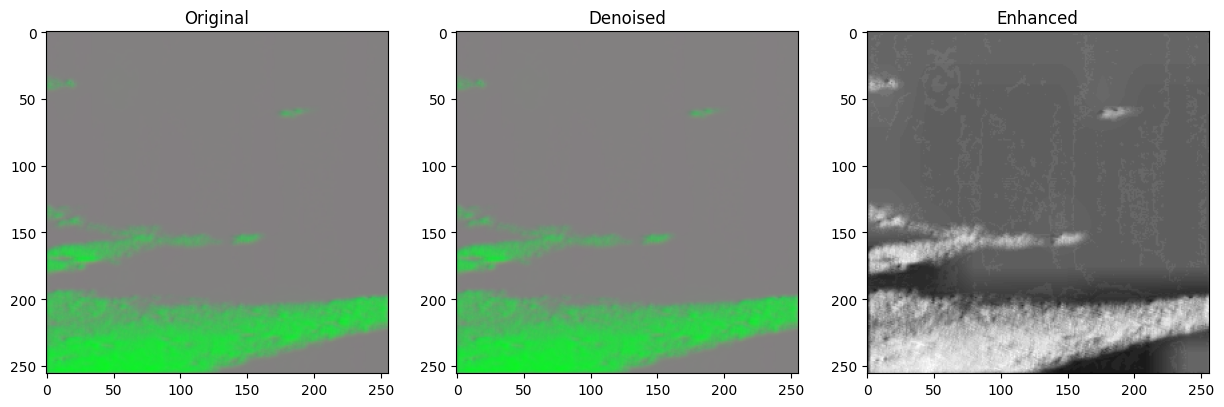

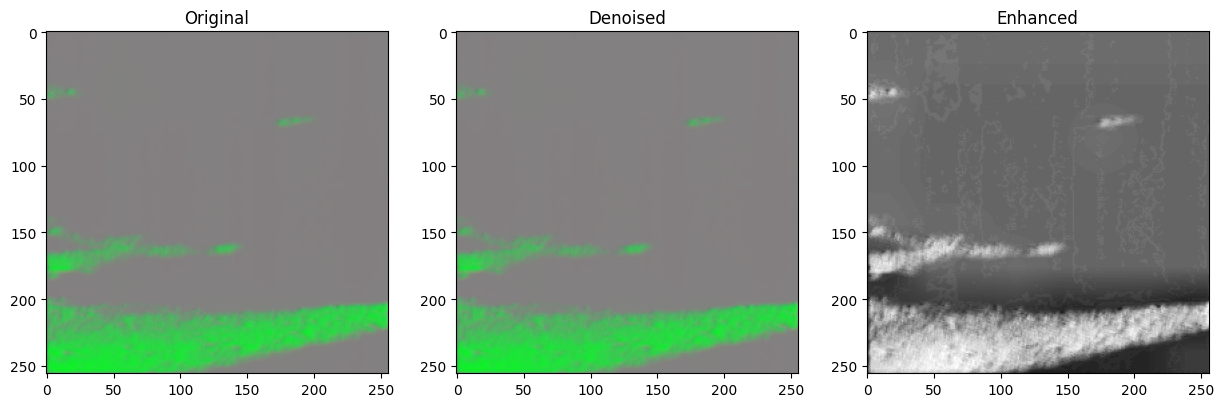

In [ ]:
# Visualize Original, Denoised, and Final Enhanced Images
def visualize_images(original_dir, denoised_dir, enhanced_dir, num_images=5):
    original_files = sorted(os.listdir(original_dir))[:num_images]
    denoised_files = sorted(os.listdir(denoised_dir))[:num_images]
    enhanced_files = sorted(os.listdir(enhanced_dir))[:num_images]

    for orig, denoised, enhanced in zip(original_files, denoised_files, enhanced_files):
        orig_img = cv2.imread(os.path.join(original_dir, orig))
        denoised_img = cv2.imread(os.path.join(denoised_dir, denoised))
        enhanced_img = cv2.imread(os.path.join(enhanced_dir, enhanced), cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original")
        plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
        plt.subplot(1, 3, 2)
        plt.title("Denoised")
        plt.imshow(cv2.cvtColor(denoised_img, cv2.COLOR_BGR2RGB))
        plt.subplot(1, 3, 3)
        plt.title("Enhanced")
        plt.imshow(enhanced_img, cmap='gray')
        plt.show()

visualize_images(output_dir, denoised_dir, enhanced_dir)
